# 2023 전력사용량 예측 AI 경진대회

In [160]:
# 라이브러리 호출
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tcn import TCN
from sklearn.preprocessing import StandardScaler

## 데이터 전처리

In [161]:
building_info = pd.read_csv('train_dataset/building_info.csv')
train = pd.read_csv('train_dataset/train.csv')

In [162]:
building_info

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1,건물기타,110634.00,39570.00,-,-,-
1,2,건물기타,122233.47,99000.00,-,-,-
2,3,건물기타,171243.00,113950.00,40,-,-
3,4,건물기타,74312.98,34419.62,60,-,-
4,5,건물기타,205884.00,150000.00,-,2557,1000
...,...,...,...,...,...,...,...
95,96,호텔및리조트,93314.00,60500.00,-,-,-
96,97,호텔및리조트,55144.67,25880.00,-,-,-
97,98,호텔및리조트,53578.62,17373.75,-,-,-
98,99,호텔및리조트,53499.00,40636.00,-,-,-


In [163]:
building_info.drop('태양광용량(kW)', axis=1, inplace=True)
building_info.drop('PCS용량(kW)', axis=1, inplace=True)
building_info.drop('ESS저장용량(kWh)', axis=1, inplace=True)
building_info.columns = ['num', 'type', 'Area', 'CoolingArea']

In [164]:
building_info

,num,type,Area,CoolingArea
0,1,건물기타,110634.00,39570.00
1,2,건물기타,122233.47,99000.00
2,3,건물기타,171243.00,113950.00
3,4,건물기타,74312.98,34419.62
4,5,건물기타,205884.00,150000.00
...,...,...,...,...
95,96,호텔및리조트,93314.00,60500.00
96,97,호텔및리조트,55144.67,25880.00
97,98,호텔및리조트,53578.62,17373.75
98,99,호텔및리조트,53499.00,40636.00


In [165]:
types = list(set(building_info['type']))
types = {i:e for e, i in enumerate(types)}
types

{'백화점및아울렛': 0,
 '상용': 1,
 '할인마트': 2,
 '데이터센터': 3,
 '지식산업센터': 4,
 '공공': 5,
 '병원': 6,
 '연구소': 7,
 '아파트': 8,
 '대학교': 9,
 '건물기타': 10,
 '호텔및리조트': 11}

In [166]:
for i in range(len(building_info)):
    building_info.loc[i, 'type'] = types[building_info.loc[i, 'type']]

In [167]:
building_info

,num,type,Area,CoolingArea
0,1,10,110634.00,39570.00
1,2,10,122233.47,99000.00
2,3,10,171243.00,113950.00
3,4,10,74312.98,34419.62
4,5,10,205884.00,150000.00
...,...,...,...,...
95,96,11,93314.00,60500.00
96,97,11,55144.67,25880.00
97,98,11,53578.62,17373.75
98,99,11,53499.00,40636.00


In [168]:
train['num_date_time'] = [int(train.loc[i, 'num_date_time'][-2:]) for i in range(len(train))]

In [169]:
train

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,0,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,2,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,3,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,4,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40
...,...,...,...,...,...,...,...,...,...,...
203995,19,100,20220824 19,23.1,NaN,0.9,86.0,0.5,NaN,881.04
203996,20,100,20220824 20,22.4,NaN,1.3,86.0,0.0,NaN,798.96
203997,21,100,20220824 21,21.3,NaN,1.0,92.0,NaN,NaN,825.12
203998,22,100,20220824 22,21.0,NaN,0.3,94.0,NaN,NaN,640.08


In [170]:
train.drop(labels='일시', axis=1, inplace=True)

In [171]:
train.columns = ['time', 'building_num', 'Temperature', 'rain(mm)', 'wind', 'humidity', 'sunshine(hr)', 'insolation(hr)', 'electricity']

In [172]:
train.drop(labels='rain(mm)', axis=1, inplace=True)
train.drop(labels='sunshine(hr)', axis=1, inplace=True)
train.drop(labels='insolation(hr)', axis=1, inplace=True)

In [173]:
train

,time,building_num,Temperature,wind,humidity,electricity
0,0,1,18.6,0.9,42.0,1085.28
1,1,1,18.0,1.1,45.0,1047.36
2,2,1,17.7,1.5,45.0,974.88
3,3,1,16.7,1.4,48.0,953.76
4,4,1,18.4,2.8,43.0,986.40
...,...,...,...,...,...,...
203995,19,100,23.1,0.9,86.0,881.04
203996,20,100,22.4,1.3,86.0,798.96
203997,21,100,21.3,1.0,92.0,825.12
203998,22,100,21.0,0.3,94.0,640.08


In [175]:
train['building_type'] = [building_info.loc[train.loc[i, 'building_num']-1, 'type'] for i in range(len(train))]

In [176]:
train

,time,building_num,Temperature,wind,humidity,electricity,building_type
0,0,1,18.6,0.9,42.0,1085.28,10
1,1,1,18.0,1.1,45.0,1047.36,10
2,2,1,17.7,1.5,45.0,974.88,10
3,3,1,16.7,1.4,48.0,953.76,10
4,4,1,18.4,2.8,43.0,986.40,10
...,...,...,...,...,...,...,...
203995,19,100,23.1,0.9,86.0,881.04,11
203996,20,100,22.4,1.3,86.0,798.96,11
203997,21,100,21.3,1.0,92.0,825.12,11
203998,22,100,21.0,0.3,94.0,640.08,11


In [177]:
train['Area'] = [building_info.loc[train.loc[i, 'building_num']-1, 'Area'] for i in range(len(train))]
train['CoolingArea'] = [building_info.loc[train.loc[i, 'building_num']-1, 'CoolingArea'] for i in range(len(train))]

In [178]:
train.dropna(inplace=True)

### 각 특성 간의 상관관계 파악

In [180]:
fig, ax = plt.subplots(figsize=(9,9))

sns.heatmap(train.corr(), annot=True, ax=ax)

# plt.title('train data relation')
# plt.show()

<AxesSubplot: >

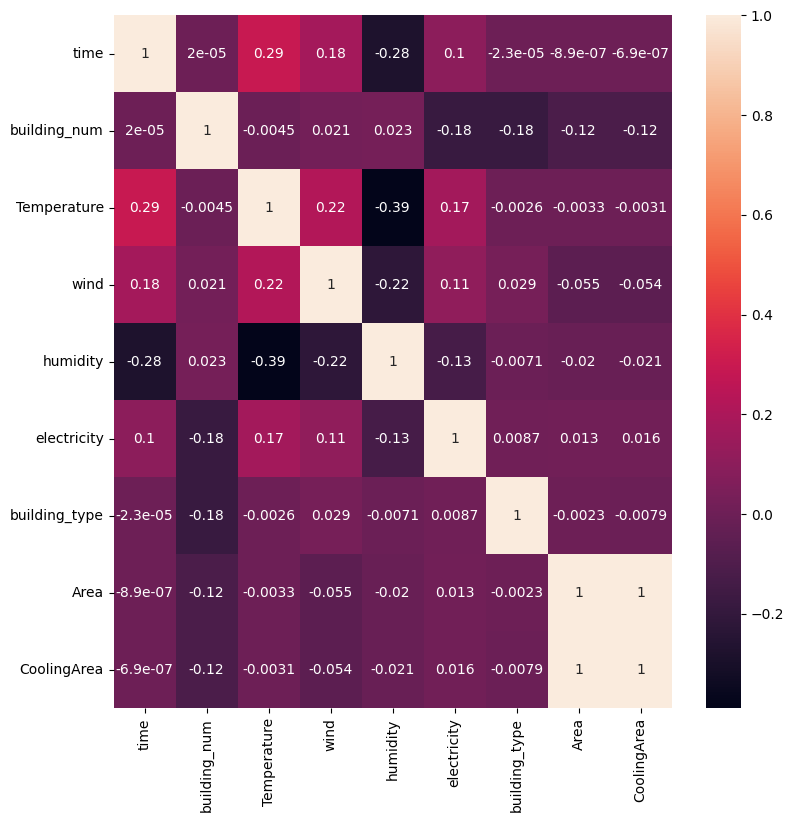

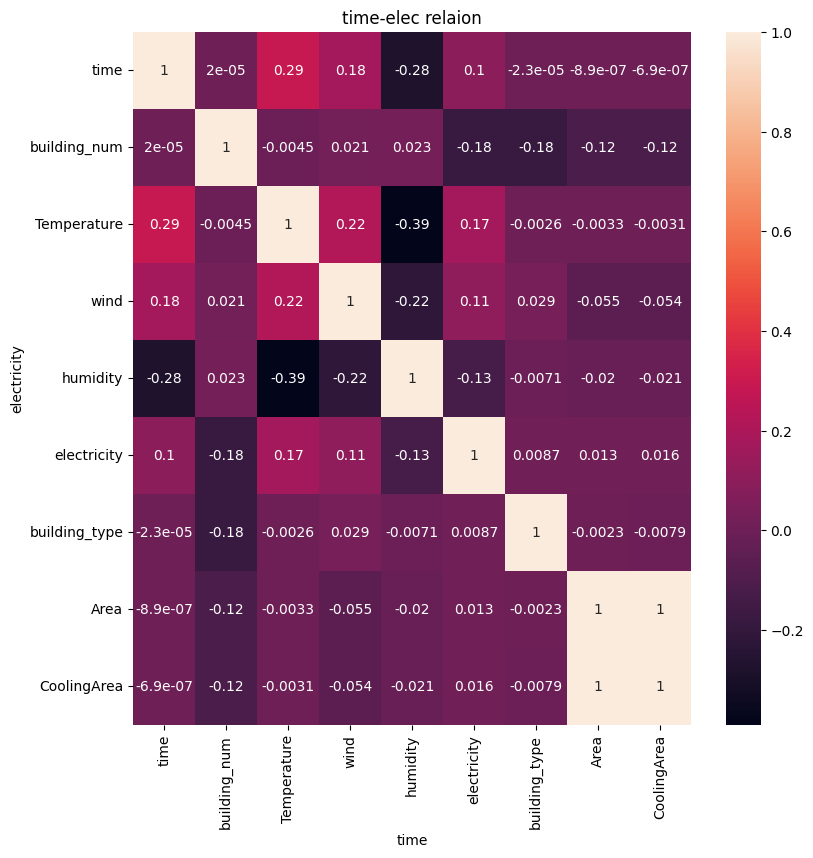

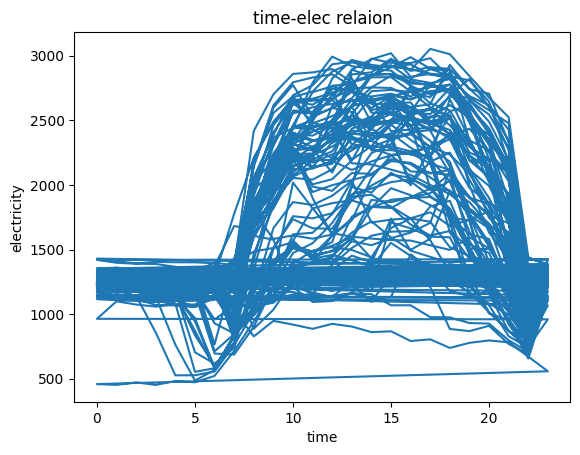

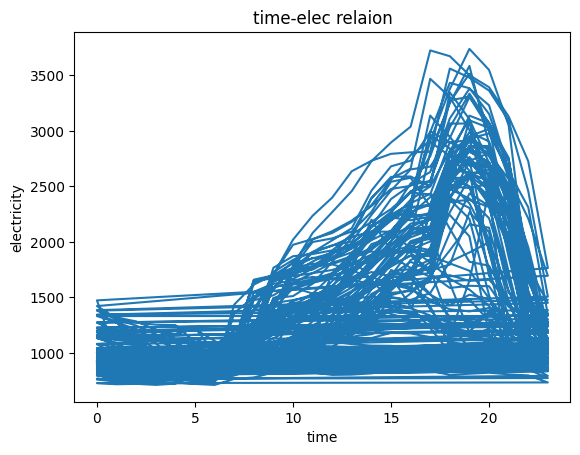

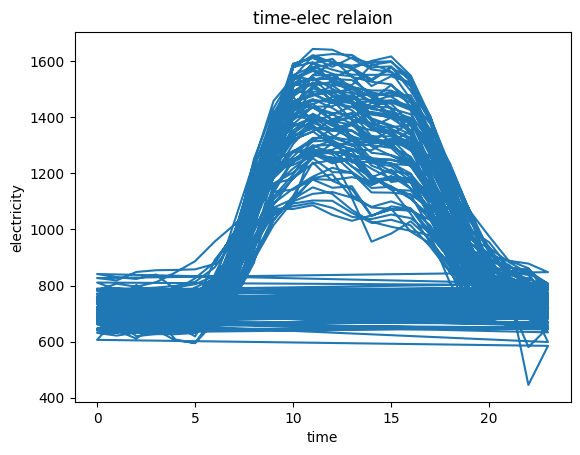

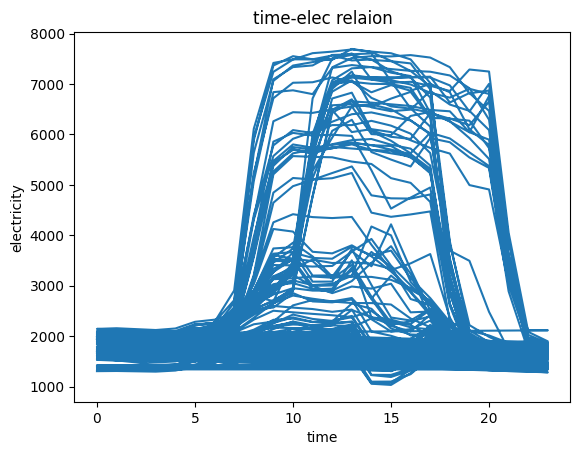

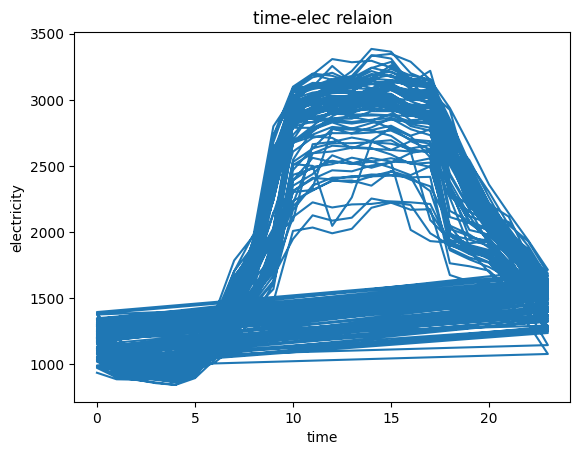

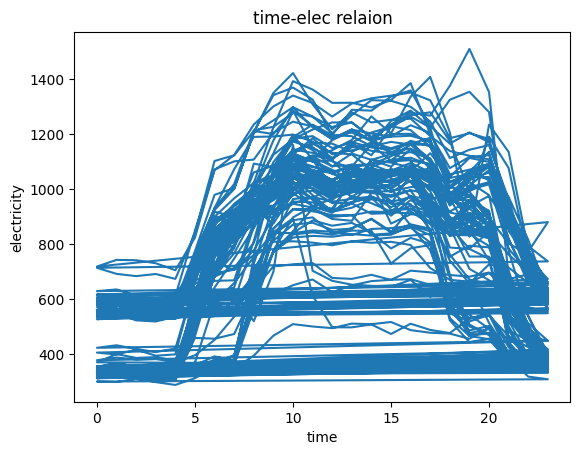

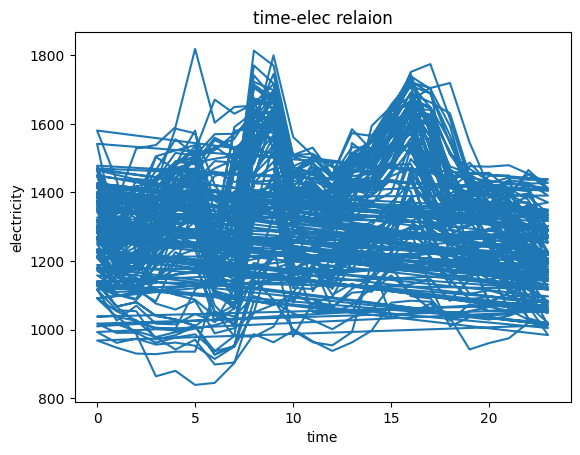

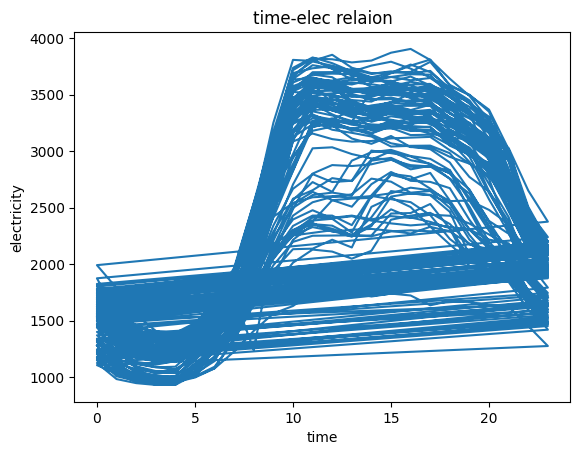

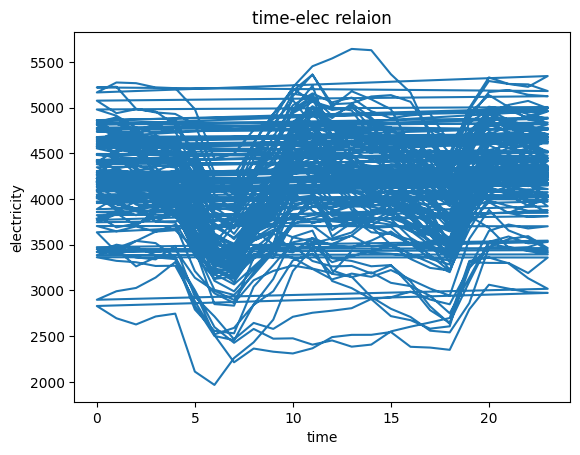

In [181]:
for i in range(1, 11):
    plt.plot(train[train['building_num']==i]['time'], train[train['building_num']==i]['electricity'])
    plt.xlabel('time')
    plt.ylabel('electricity')
    plt.title('time-elec relaion')
    plt.show()

### 건물별로 데이터 분리

In [206]:
timeScale = StandardScaler().fit(np.array(train['time']).reshape(-1,1))
windScale = StandardScaler().fit(np.array(train['wind']).reshape(-1,1))
building_numScale = StandardScaler().fit(np.array(train['building_num']).reshape(-1,1))
TemperatureScale = StandardScaler().fit(np.array(train['Temperature']).reshape(-1,1))
humidityScale = StandardScaler().fit(np.array(train['humidity']).reshape(-1,1))
electricityScale = StandardScaler().fit(np.array(train['electricity']).reshape(-1,1))

In [207]:
for i in range(1, 101):
    exec(f'train{i} = train[train["building_num"]=={i}]')

### 데이터 정규화

In [208]:
for i in range(1, 101):
    for col in ['time', 'building_num', 'wind', 'Temperature', 'humidity', 'electricity']:
        exec(f'train{i}[col] = {col}Scale.transform(np.array(train{i}[col]).reshape(-1, 1))')

<string>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<string>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<string>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<string>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

### 학습, 검증 데이터 분리

In [209]:
for i in range(1, 101):
    exec(f"train{i}_x, test{i}_x, train{i}_y, test{i}_y = train_test_split(\
         train{i}[['time', 'building_num', 'wind', 'Temperature', 'humidity']],\
            train{i}['electricity'], test_size=0.2, shuffle=False)")

### window 처리
- https://blog.naver.com/sunghyeon98/222459222648
- https://youtu.be/NUMzrqxQ4zk

In [226]:
def windowed_dataset(x, y, window_size, batch_size, shuffle=False):
    ds_x = tf.data.Dataset.from_tensor_slices(x)
    ds_x = ds_x.window(window_size, shift=1, stride=1, drop_remainder=True)
    ds_x = ds_x.flat_map(lambda w : w.batch(window_size))
    ds_y = tf.data.Dataset.from_tensor_slices(y[window_size:])
    ds = tf.data.Dataset.zip((ds_x, ds_y))
    if shuffle:
        ds = ds.shuffle(1000)
    return ds.batch(batch_size)

In [227]:
WINDOW_SIZE = 5
BATCH_SIZE = 10

In [229]:
train_dataset = windowed_dataset(train1_x, train1_y, WINDOW_SIZE, BATCH_SIZE)
test_dataset = windowed_dataset(test1_x, test1_y, WINDOW_SIZE, BATCH_SIZE)
for i in range(2, 101):
   train_dataset = tf.data.Dataset.concatenate(eval(f'windowed_dataset(train{i}_x, train{i}_y, WINDOW_SIZE, BATCH_SIZE)'), train_dataset)
   test_dataset = tf.data.Dataset.concatenate(eval(f'windowed_dataset(test{i}_x, test{i}_y, WINDOW_SIZE, BATCH_SIZE)'), test_dataset)

## 모델 설계

In [233]:
train_dataset.isnull().any()

AttributeError: 'ConcatenateDataset' object has no attribute 'isnull'

In [237]:
TCN_delay = [2**i for i in range(4)]

Input = tf.keras.Input(shape=(WINDOW_SIZE, 1), name='Input')
TCN_layer = TCN(nb_filters=64, kernel_size=3, padding='causal', name='TCN', dropout_rate=0.1)(Input)
dense4 = tf.keras.layers.Dense(units=1, activation='sigmoid')(TCN_layer)
DenseModel = tf.keras.Model(inputs=[Input], outputs=dense4, name='DenseModel')

In [238]:
DenseModel.compile(optimizer='adam', loss=tf.keras.losses.Huber(), metrics=['mse'])
StpCp = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
chkPoint = tf.keras.callbacks.ModelCheckpoint('models/', save_weights_only=True, save_best_only=True, monitor='val_loss')
history = DenseModel.fit(train_dataset, epochs=100, validation_data=test_dataset, callbacks=[chkPoint, StpCp])

Epoch 1/100


ValueError: in user code:

    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_filesnjy3014.py", line 48, in tf__call
        ag__.for_stmt(ag__.ld(self).residual_blocks, None, loop_body, get_state_1, set_state_1, ('x',), {'iterate_names': 'res_block'})
    File "/tmp/__autograph_generated_filesnjy3014.py", line 41, in loop_body
        (x, skip_out) = ag__.converted_call(ag__.ld(res_block), (ag__.ld(x),), dict(training=ag__.ld(training)), fscope)
    File "/tmp/__autograph_generated_filepgumqo_5.py", line 27, in tf__call
        ag__.for_stmt(ag__.ld(self).layers, None, loop_body, get_state, set_state, ('x1',), {'iterate_names': 'layer'})
    File "/tmp/__autograph_generated_filepgumqo_5.py", line 24, in loop_body
        x1 = ag__.if_exp(ag__.ld(training_flag), (lambda : ag__.converted_call(ag__.ld(layer), (ag__.ld(x1),), dict(training=ag__.ld(training)), fscope)), (lambda : ag__.converted_call(ag__.ld(layer), (ag__.ld(x1),), None, fscope)), 'training_flag')
    File "/tmp/__autograph_generated_filepgumqo_5.py", line 24, in <lambda>
        x1 = ag__.if_exp(ag__.ld(training_flag), (lambda : ag__.converted_call(ag__.ld(layer), (ag__.ld(x1),), dict(training=ag__.ld(training)), fscope)), (lambda : ag__.converted_call(ag__.ld(layer), (ag__.ld(x1),), None, fscope)), 'training_flag')

    ValueError: Exception encountered when calling layer 'TCN' (type TCN).
    
    in user code:
    
        File "/usr/local/lib/python3.8/dist-packages/tcn/tcn.py", line 344, in call  *
            x, skip_out = res_block(x, training=training)
        File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "/tmp/__autograph_generated_filepgumqo_5.py", line 27, in tf__call
            ag__.for_stmt(ag__.ld(self).layers, None, loop_body, get_state, set_state, ('x1',), {'iterate_names': 'layer'})
        File "/tmp/__autograph_generated_filepgumqo_5.py", line 24, in loop_body
            x1 = ag__.if_exp(ag__.ld(training_flag), (lambda : ag__.converted_call(ag__.ld(layer), (ag__.ld(x1),), dict(training=ag__.ld(training)), fscope)), (lambda : ag__.converted_call(ag__.ld(layer), (ag__.ld(x1),), None, fscope)), 'training_flag')
        File "/tmp/__autograph_generated_filepgumqo_5.py", line 24, in <lambda>
            x1 = ag__.if_exp(ag__.ld(training_flag), (lambda : ag__.converted_call(ag__.ld(layer), (ag__.ld(x1),), dict(training=ag__.ld(training)), fscope)), (lambda : ag__.converted_call(ag__.ld(layer), (ag__.ld(x1),), None, fscope)), 'training_flag')
    
        ValueError: Exception encountered when calling layer 'residual_block_0' (type ResidualBlock).
        
        in user code:
        
            File "/usr/local/lib/python3.8/dist-packages/tcn/tcn.py", line 175, in call  *
                x1 = layer(x1, training=training) if training_flag else layer(x1)
            File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler  **
                raise e.with_traceback(filtered_tb) from None
            File "/usr/local/lib/python3.8/dist-packages/keras/engine/input_spec.py", line 277, in assert_input_compatibility
                raise ValueError(
        
            ValueError: Input 0 of layer "conv1D_0" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (None, None, 5)
        
        
        Call arguments received by layer 'residual_block_0' (type ResidualBlock):
          • inputs=tf.Tensor(shape=(None, None, 5), dtype=float32)
          • training=True
          • kwargs=<class 'inspect._empty'>
    
    
    Call arguments received by layer 'TCN' (type TCN):
      • inputs=tf.Tensor(shape=(None, None, 5), dtype=float32)
      • training=True
      • kwargs=<class 'inspect._empty'>


In [ ]:
DenseModel.evaluate(test_x, test_y)

1913/1913 [==============================] - 17s 9ms/step - loss: 2451.9297


2451.9296875

In [ ]:
# Accuracy graph
plt.figure(1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('ElecPredict_Accuracy_1.png')
print("Saved Accuracy graph")

# Loss graph
plt.figure(2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('ElecPredict_Loss_1.png')
print("Saved Loss graph")

plt.show()

## 결과 파일 도출

In [ ]:
test = pd.read_csv('test/test.csv')
test['date'] = test['num_date_time']
test['num_date_time'] = [int(test.loc[i, 'num_date_time'][-2:]) for i in range(len(test))]
test.drop(labels='일시', axis=1, inplace=True)
test.columns = ['time(hr)', 'building_num', 'Temperature', 'rain(mm)', 'wind(m/s)', 'humidity(%)', 'num_date_time']
test.drop(labels='rain(mm)', axis=1, inplace=True)
test


,time(hr),building_num,Temperature,wind(m/s),humidity(%),num_date_time
0,0,1,23.5,2.2,72,1_20220825 00
1,1,1,23.0,0.9,72,1_20220825 01
2,2,1,22.7,1.5,75,1_20220825 02
3,3,1,22.1,1.3,78,1_20220825 03
4,4,1,21.8,1.0,77,1_20220825 04
...,...,...,...,...,...,...
16795,19,100,22.5,0.9,84,100_20220831 19
16796,20,100,20.7,0.4,95,100_20220831 20
16797,21,100,20.2,0.4,98,100_20220831 21
16798,22,100,20.1,1.1,97,100_20220831 22
